## Understanding Drone Components:


### 1. The Drone Body (Frame)

The drone's body, or frame, is its skeletal structure, providing the mounting points for all other components. It dictates the drone's size, weight, and overall durability, impacting its stability and flight characteristics. Common materials include carbon fiber for strength and lightness, or plastic for affordability.

### 2. The Battery

The battery is the power source for the entire drone system, typically Lithium Polymer (LiPo) batteries due to their high energy density. Understanding battery specifications is crucial for safe operation and optimal flight performance. Let's look at some key conventions:

*   **Voltage Rating (V)**: This indicates the nominal voltage of the battery, determined by the number of cells (e.g., a 3S battery has 3 cells in series, roughly 11.1V). Higher voltage generally means more power available for the motors.

*   **mAh Rating (Milliampere-hour)**: This represents the battery's capacity, or how much charge it can hold. A higher mAh rating means a longer flight time, but usually also a heavier battery.

*   **C-Rating**: This is a multiplier that tells you the maximum continuous discharge rate of the battery. For example, a 1500mAh 30C battery can safely discharge 1.5A * 30 = 45A Amps.
For eg: 1500mah 130C can discharge a current of 1.5*130= 195A

Power = Voltage*Amps
Kv rating = voltage * Mah

Burst Power(1st battery: 3s) 11.1v*45A = 500W

Burst Power(2nd battery: 4s) 14.8v*195A = 2886W

2886/500 = 5.7X times

*   **Power**: While not directly a rating on the battery, power (measured in Watts) is derived from voltage and current (Power = Voltage × Current). It's the total energy supplied to the motors and electronics, directly influencing the drone's thrust and performance.

### 3. The Flight Controller (FC)

The flight controller is the brain of the drone, processing sensor data and sending commands to the motors to maintain stable flight and execute pilot inputs. It runs complex algorithms to interpret acceleration, angular velocity, and orientation, translating them into precise motor speeds. A popular example for DIY and professional applications is the **Pixhawk 2.4.8**, known for its reliability and open-source nature.

### 4. Flight Control Software

Beyond the hardware, software is essential for defining how the drone flies and behaves. This firmware runs on the flight controller and provides all the intelligence. Key platforms include:

*   **ArduPilot**: A powerful, open-source autopilot software suite supporting a wide range of vehicles, including multirotors, fixed-wing aircraft, and even submarines. It's highly configurable and offers advanced features like autonomous missions, precision landing, and obstacle avoidance. We will be focusing more on ArduPilot's capabilities.

*   **BetaFlight**: Primarily used for FPV (First Person View) racing drones, BetaFlight is optimized for high-performance, acrobatic flight with very low latency. It provides a highly responsive and customizable flying experience.

*   **INAV**: Similar to BetaFlight, INAV is geared towards GPS-enabled FPV drones, offering navigation features like waypoint missions and 'return to home', making it suitable for longer-range and more autonomous flights.

### 5. Connecting Drones to Machine Learning

The world of drones is increasingly intertwined with machine learning, enabling capabilities far beyond manual flight. Here's how various ML concepts play a crucial role:

*   **Autonomous Navigation & Image Classification**: For a drone to navigate autonomously, it often needs to 'see' and understand its environment. **Neural Networks** are instrumental here, particularly for **Image Classification** tasks, allowing the drone to identify objects, avoid obstacles, or follow specific targets from camera feeds.

*   **Sensor Fusion & Stabilization**: Drones rely on a multitude of sensors, such as IMUs (Inertial Measurement Units) which provide accelerometer and gyroscope data. Machine learning algorithms, including advanced **Regression** techniques or even neural networks, can process and fuse this noisy sensor input to estimate the drone's precise orientation and position, ensuring stable flight even in turbulent conditions.

*   **Predictive Maintenance & Anomaly Detection**: ML models can analyze flight data (motor temperatures, battery discharge rates, vibration patterns) to predict component failures before they occur, optimizing maintenance schedules. They can also detect anomalous flight behaviors that might indicate a problem.

*   **Path Planning & Optimization**: Reinforcement Learning, a branch of AI, can be used to train drones to find optimal paths in complex environments, learning from trial and error to perform tasks efficiently and safely, such as package delivery or inspection.

### Demo: Sensor Data Smoothing and Altitude Prediction


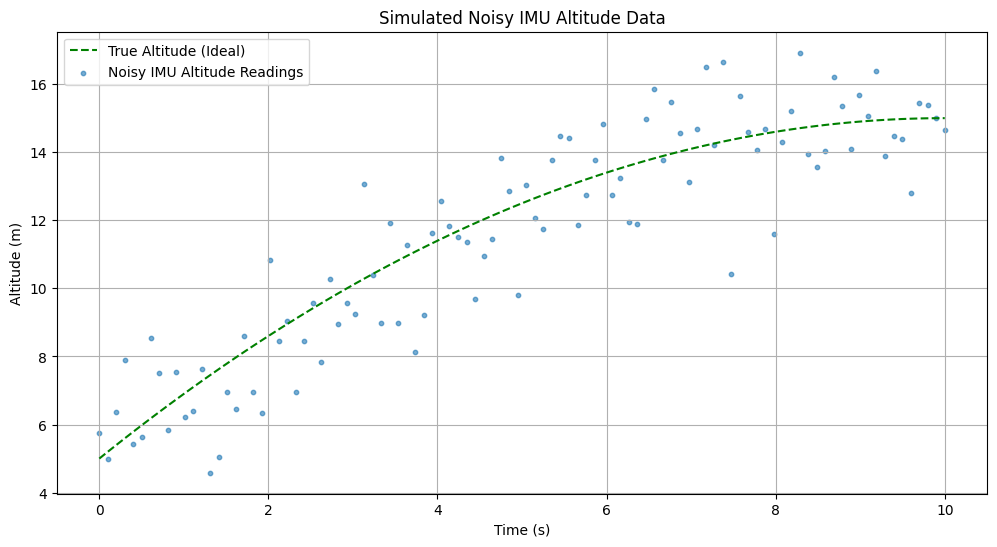

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# 1. Generate synthetic noisy IMU data for altitude
np.random.seed(42)
num_samples = 100

# Simulate time steps
time = np.linspace(0, 10, num_samples)

# Simulate a true altitude profile (e.g., ascending, hovering, descending)
true_altitude = 2 * time - 0.1 * time**2 + 5  # Parabolic path

# Add noise to simulate IMU sensor readings
noisy_altitude = true_altitude + np.random.normal(0, 1.5, num_samples)

plt.figure(figsize=(12, 6))
plt.plot(time, true_altitude, label='True Altitude (Ideal)', color='green', linestyle='--')
plt.scatter(time, noisy_altitude, label='Noisy IMU Altitude Readings', alpha=0.6, s=10)
plt.title('Simulated Noisy IMU Altitude Data')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid(True)
plt.show()

#### 2. Data Smoothing

Sensor data often contains noise that can obscure the true signal. Smoothing techniques help to reduce this noise, making the data more reliable for analysis and prediction. Here, we'll use a simple moving average.

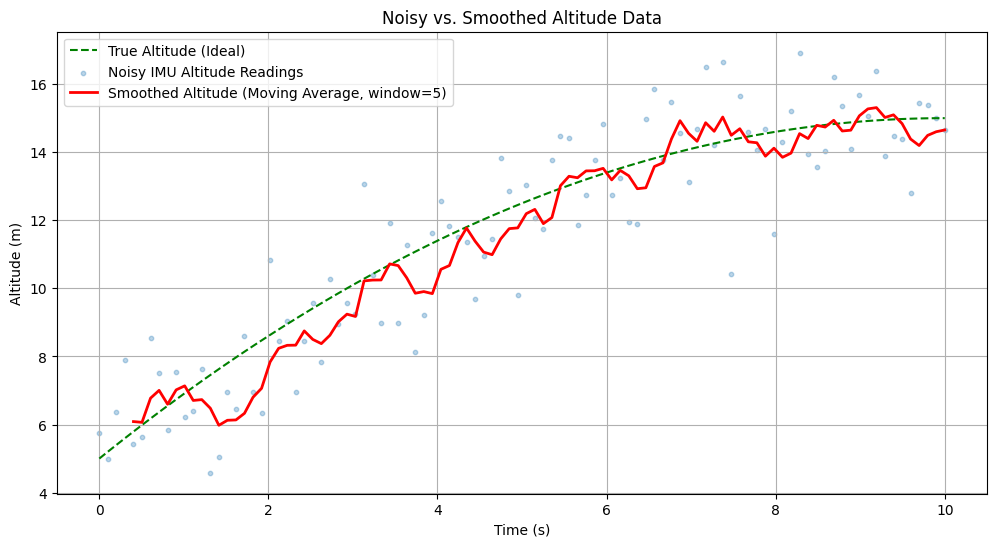

In [2]:
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

window_size = 5 # Number of data points to average
smoothed_altitude = moving_average(noisy_altitude, window_size)

# Adjust time for smoothed data to match its length
time_smoothed = time[window_size - 1:]

plt.figure(figsize=(12, 6))
plt.plot(time, true_altitude, label='True Altitude (Ideal)', color='green', linestyle='--')
plt.scatter(time, noisy_altitude, label='Noisy IMU Altitude Readings', alpha=0.3, s=10)
plt.plot(time_smoothed, smoothed_altitude, label=f'Smoothed Altitude (Moving Average, window={window_size})', color='red', linewidth=2)
plt.title('Noisy vs. Smoothed Altitude Data')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid(True)
plt.show()

#### 3. Altitude Prediction using Polynomial Regression

After smoothing, we can use machine learning models like polynomial regression to predict the drone's altitude based on time. This can be crucial for autonomous flight, precise landing, or mission planning.

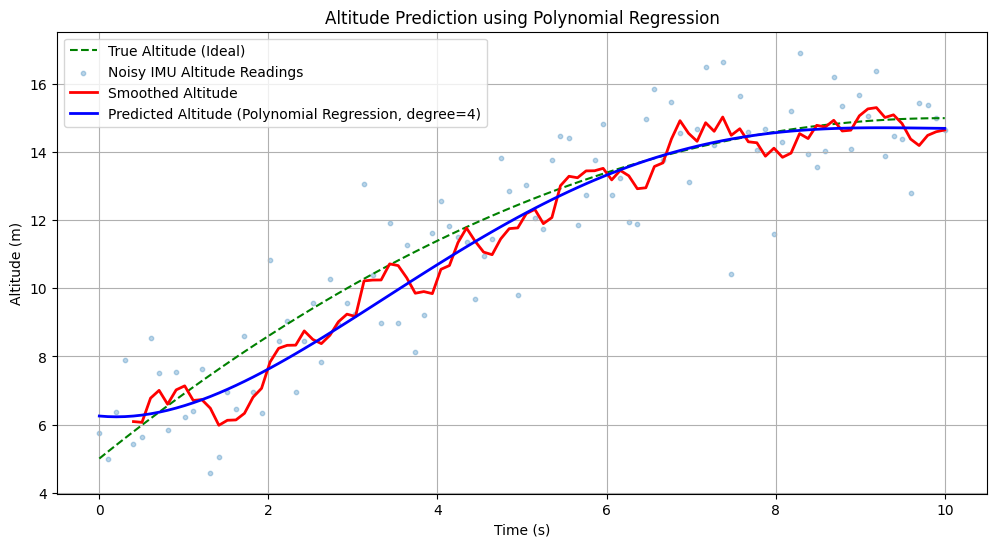

In [7]:
degree = 4 # Degree of the polynomial regression

# Create a pipeline for polynomial regression
# We use the smoothed data for training the model for better accuracy
poly_model = make_pipeline(PolynomialFeatures(degree),
                           LinearRegression())

# Reshape time for sklearn (needs to be 2D array)
X = time_smoothed.reshape(-1, 1)
y = smoothed_altitude

# Train the model
poly_model.fit(X, y)

# Predict altitude over the full time range for visualization
time_full_range = time.reshape(-1, 1)
predicted_altitude = poly_model.predict(time_full_range)

plt.figure(figsize=(12, 6))
plt.plot(time, true_altitude, label='True Altitude (Ideal)', color='green', linestyle='--')
plt.scatter(time, noisy_altitude, label='Noisy IMU Altitude Readings', alpha=0.3, s=10)
plt.plot(time_smoothed, smoothed_altitude, label='Smoothed Altitude', color='red', linewidth=2)
plt.plot(time, predicted_altitude, label=f'Predicted Altitude (Polynomial Regression, degree={degree})', color='blue', linewidth=2)
plt.title('Altitude Prediction using Polynomial Regression')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid(True)
plt.show()

#### 4. Altitude Prediction using a Simple Neural Network

 Neural Network to predict the altitude. Neural networks can capture more complex patterns in data and are widely used in various drone applications, including control systems and autonomous navigation.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


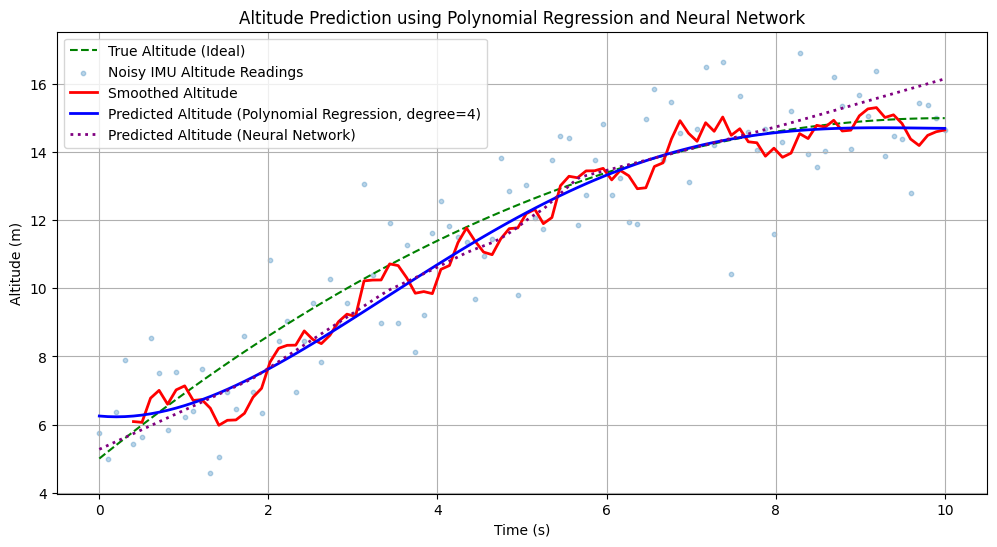

In [8]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Prepare data for Neural Network
# We'll use the smoothed data for training
X_nn = time_smoothed.reshape(-1, 1)
y_nn = smoothed_altitude.reshape(-1, 1)

# Scale the input features (time) and output (altitude) for better NN performance
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_nn_scaled = scaler_X.fit_transform(X_nn)
y_nn_scaled = scaler_y.fit_transform(y_nn)

# Define a simple Sequential Neural Network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(1,)), # Input layer with 1 feature (time)
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1) # Output layer with 1 neuron (altitude)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_nn_scaled, y_nn_scaled, epochs=200, verbose=0, validation_split=0.2)

# Make predictions over the full time range
time_full_range_scaled = scaler_X.transform(time.reshape(-1, 1))
predicted_altitude_nn_scaled = model.predict(time_full_range_scaled)

# Inverse transform to get actual altitude values
predicted_altitude_nn = scaler_y.inverse_transform(predicted_altitude_nn_scaled)

plt.figure(figsize=(12, 6))
plt.plot(time, true_altitude, label='True Altitude (Ideal)', color='green', linestyle='--')
plt.scatter(time, noisy_altitude, label='Noisy IMU Altitude Readings', alpha=0.3, s=10)
plt.plot(time_smoothed, smoothed_altitude, label='Smoothed Altitude', color='red', linewidth=2)
plt.plot(time, predicted_altitude, label=f'Predicted Altitude (Polynomial Regression, degree={degree})', color='blue', linewidth=2)
plt.plot(time, predicted_altitude_nn, label='Predicted Altitude (Neural Network)', color='purple', linewidth=2, linestyle=':')

plt.title('Altitude Prediction using Polynomial Regression and Neural Network')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid(True)
plt.show()

This expanded visualization now includes the neural network's prediction (purple dotted line), showing its capability to model the altitude changes. Neural networks can be very powerful for handling more complex and non-linear relationships in real-world drone data.